---

## Portfolio Management

How will portfolio management will be used:

1. Will handle the data and its length (it will call the data that is going to be used by all individual strategies)
2. Will call each strategy and get its returns columns (Will loop over each strategy class)
-> Note: Each strategy will already have an optimizer in each of their class (will be already walk forwarded)
3. Construct relevant methods

Thus:
- A method to call all strategies data + combines all of their cumulative return into one df
- Methods that calculates any factors affecting the choice of the strategies as well as their weights (Correlations, Market Regime, ...)

The portfolio management is a layer that manages the current best strategies and its objective is to generate a weight multiplier for each strategy based on factors allowing dynamic rebalancing. It classifies strategies, Calculates the correlation between strategies, provide a market regime detection model that may impact the weights of specific strategy types, ...


Note that everything in this module will be applied before running the process of optimization. Any management layers occuring after the rebalancing, are located inside the portfolio risk management module.


---

idea for portfolio management: get all the strategies -> run them -> do that analysis and filtering (correlation analysis, ...)

Get the data, and call all strategies to get the out of sample performance

In [1]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_Management'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Trend_Following')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low


In [2]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [ ]:
start_time = dt.datetime(2024, 7, 1)
end_time = dt.datetime(2025, 1, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

close  creturns        high  log_return  \
date                coin                                                    
2024-01-01 01:00:00 ADAUSDT      0.6023  1.007359      0.6029    0.007332   
                    BNBUSDT    315.3000  1.002863    316.0000    0.002859   
                    BTCUSDT  42613.5600  1.003257  42775.0000    0.003251   
                    ETHUSDT   2303.7200  1.003577   2306.6000    0.003570   
2024-01-01 02:00:00 ADAUSDT      0.5995  1.002676      0.6027   -0.004660   
...                                 ...       ...         ...         ...   
2024-12-31 22:00:00 ETHUSDT   3339.8800  1.454962   3352.6400   -0.003846   
2024-12-31 23:00:00 ADAUSDT      0.8451  1.413447      0.8467    0.000947   
                    BNBUSDT    702.3000  2.233779    702.6900    0.001753   
                    BTCUSDT  93576.0000  2.203072  93756.0000    0.000932   
                    ETHUSDT   3337.7800  1.454047   3345.9800   -0.000629   

                                    low        open       price   returns  \
date                coin                                                    
2024-01-01 01:00:00 ADAUSDT      0.5966      0.5979      0.6023  0.007359   
                    BNBUSDT    314.1000    314.3000    315.3000  0.002863   
                    BTCUSDT  42431.6500  42475.2300  42613.5600  0.003257   
                    ETHUSDT   2292.9000   2295.5200   2303.7200  0.003577   
2024-01-01 02:00:00 ADAUSDT      0.5979      0.6023      0.5995 -0.004649   
...                                 ...         ...         ...       ...   
2024-12-31 22:00:00 ETHUSDT   3329.0000   3352.6400   3339.8800 -0.003839   
2024-12-31 23:00:00 ADAUSDT      0.8423      0.8442      0.8451  0.000948   
                    BNBUSDT    699.3900    701.0700    702.3000  0.001754   
                    BTCUSDT  93375.3800  93488.8300  93576.0000  0.000932   
                    ETHUSDT   3328.4700   3339.8800   3337.7800 -0.000629   

                                   volume  volume_in_dollars  
date                coin                                      
2024-01-01 01:00:00 ADAUSDT  2.607607e+06       1.570562e+06  
                    BNBUSDT  1.555812e+04       4.905474e+06  
                    BTCUSDT  1.196379e+03       5.098195e+07  
                    ETHUSDT  8.413426e+03       1.938218e+07  
2024-01-01 02:00:00 ADAUSDT  1.791058e+06       1.073740e+06  
...                                   ...                ...  
2024-12-31 22:00:00 ETHUSDT  8.990506e+03       3.002721e+07  
2024-12-31 23:00:00 ADAUSDT  2.176811e+06       1.839623e+06  
                    BNBUSDT  4.775590e+03       3.353897e+06  
                    BTCUSDT  3.365799e+02       3.149581e+07  
                    ETHUSDT  6.082788e+03       2.030301e+07  

[35132 rows x 10 columns]

In [2]:
market_data = pd.read_csv('market_data.csv', index_col=['date', 'coin'], parse_dates=['date'])
market_data

close  creturns          high  log_return  \
date                coin                                                        
2024-07-10 01:00:00 ADAUSDT      0.376500  1.010738      0.376900    0.010681   
                    BTCUSDT  57798.890000  1.005436  58000.010000    0.005422   
                    ETHUSDT   3059.040000  1.008519   3069.000000    0.008483   
                    XRPUSDT      0.433700  1.002311      0.435200    0.002308   
                    YGGUSDT      0.436000  1.012541      0.438800    0.012463   
...                                   ...       ...           ...         ...   
2025-01-14 05:00:00 ADAUSDT      0.955988  1.012087      0.963367   -0.000259   
                    BTCUSDT  95140.000000  1.006910  95400.000000    0.000798   
                    ETHUSDT   3169.000000  1.010475   3179.310000   -0.000984   
                    XRPUSDT      2.535960  1.004380      2.549990   -0.000532   
                    YGGUSDT      0.413000  1.000000      0.413000    0.000000   

                                      low          open         price  \
date                coin                                                
2024-07-10 01:00:00 ADAUSDT      0.371800      0.372600      0.376500   
                    BTCUSDT  57309.090000  57486.380000  57798.890000   
                    ETHUSDT   3024.000000   3033.190000   3059.040000   
                    XRPUSDT      0.431700      0.432800      0.433700   
                    YGGUSDT      0.428900      0.430600      0.436000   
...                                   ...           ...           ...   
2025-01-14 05:00:00 ADAUSDT      0.954852      0.957228      0.955988   
                    BTCUSDT  95064.100000  95064.100000  95140.000000   
                    ETHUSDT   3163.810000   3172.130000   3169.000000   
                    XRPUSDT      2.531940      2.537320      2.535960   
                    YGGUSDT      0.413000      0.413000      0.413000   

                              returns        volume  volume_in_dollars  
date                coin                                                
2024-07-10 01:00:00 ADAUSDT  0.010738  1.547117e+06       5.824895e+05  
                    BTCUSDT  0.005436  9.540997e+02       5.514591e+07  
                    ETHUSDT  0.008519  8.748505e+03       2.676203e+07  
                    XRPUSDT  0.002311  1.938982e+07       8.409363e+06  
                    YGGUSDT  0.012541  6.133780e+05       2.674328e+05  
...                               ...           ...                ...  
2025-01-14 05:00:00 ADAUSDT -0.000259  1.055745e+05       1.009280e+05  
                    BTCUSDT  0.000798  4.025751e+01       3.830099e+06  
                    ETHUSDT -0.000984  2.123849e+02       6.730478e+05  
                    XRPUSDT -0.000532  2.872629e+05       7.284872e+05  
                    YGGUSDT  0.000000  0.000000e+00       0.000000e+00  

[22585 rows x 10 columns]

---

Call each Strategy

In [3]:
mr_strat_1 = Last_Days_Low(data, objective = 'multiple', train_size = 440, test_size = 200, step_size = 50)
tf_strat_1 = Sprtrnd_Breakout(data, objective = 'multiple', train_size = 440, test_size = 200, step_size = 50)

In [ ]:
mr_strat_1.test()

In [ ]:
tf_strat_1.test()

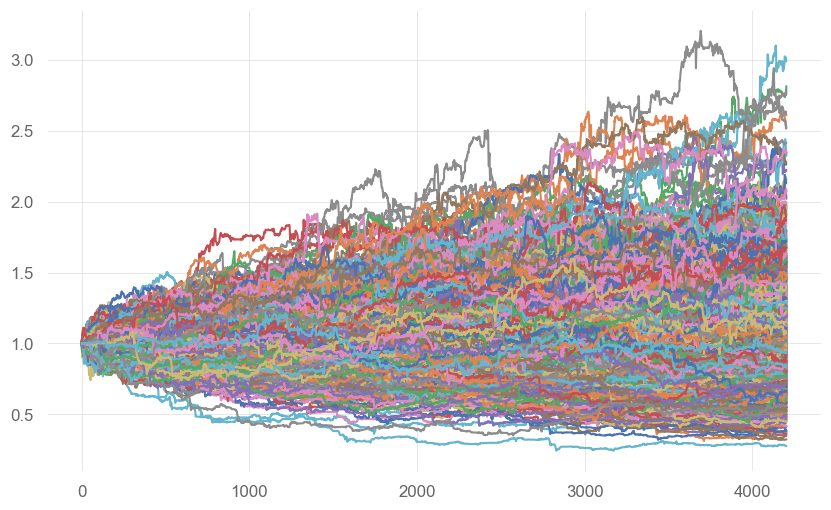

In [6]:
mr_strat_1.stress_test()

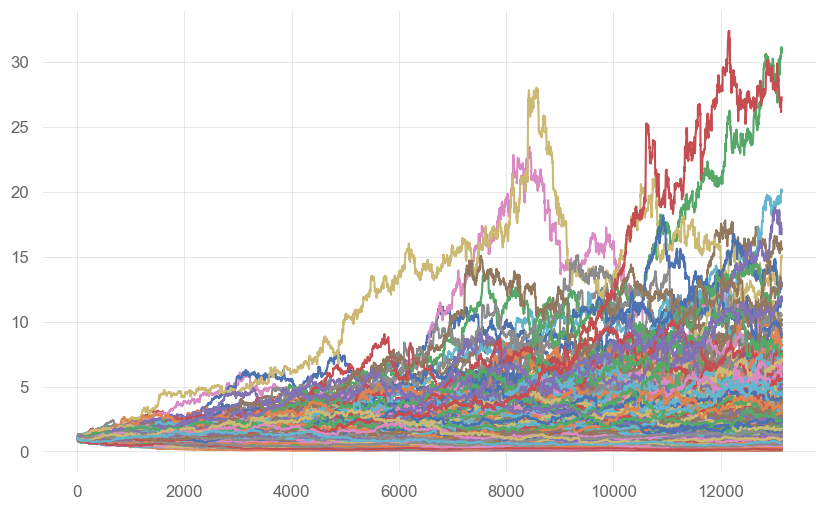

In [7]:
tf_strat_1.stress_test()

In [21]:
tf_strat_1.metrics_df.describe()

,max_drawdown,avg_drawdown,avg_drawdown_duration,sharpe_ratio,var,cvar
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.696031,-0.272780,107.542913,0.027144,-0.012900,-0.024468
std,0.119510,0.111762,99.940546,0.012969,0.000550,0.001516
min,-0.975991,-0.818909,1.666667,-0.018411,-0.015011,-0.029757
25%,-0.786858,-0.325005,66.695120,0.017933,-0.013305,-0.025509
50%,-0.693072,-0.246398,84.334791,0.027582,-0.012919,-0.024401
75%,-0.605630,-0.193455,118.088645,0.035682,-0.012484,-0.023397
max,-0.365868,-0.093280,2085.166667,0.068697,-0.011181,-0.020118


In [22]:
mr_strat_1.metrics_df.describe()

,max_drawdown,avg_drawdown,avg_drawdown_duration,sharpe_ratio,var,cvar
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.400435,-0.149600,58.369951,0.026993,-0.011008,-0.019650
std,0.114411,0.080898,68.678246,0.020992,0.000626,0.001751
min,-0.791304,-0.561319,0.000000,-0.033790,-0.013209,-0.027173
25%,-0.474041,-0.190074,30.953115,0.011613,-0.011435,-0.020850
50%,-0.389587,-0.128266,42.379189,0.026125,-0.011185,-0.019559
75%,-0.311804,-0.090817,62.315363,0.040863,-0.010548,-0.018399
max,-0.175872,-0.033783,1111.000000,0.091719,-0.008671,-0.014878


<Axes: xlabel='date,coin'>

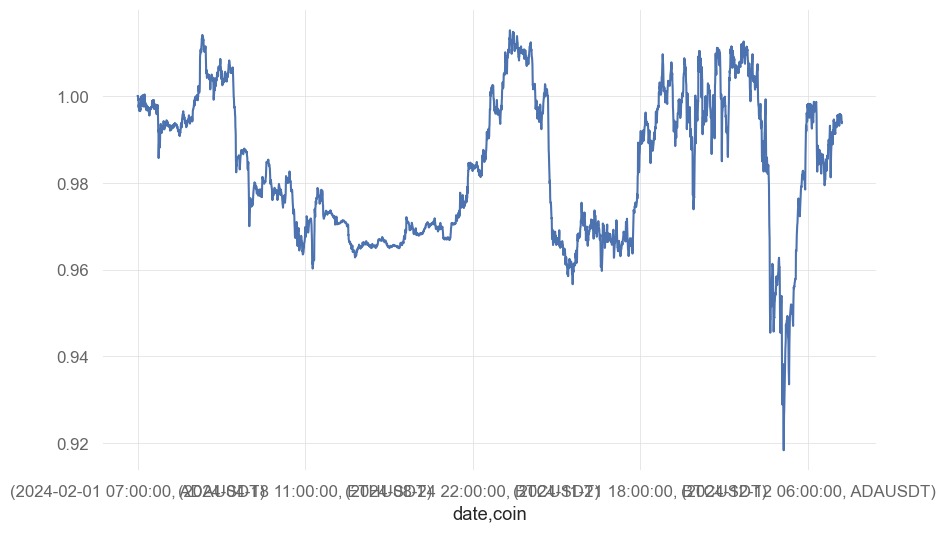

In [9]:
mr_strat_1.results.cstrategy.plot()

In [ ]:
(mr_strat_1.results.strategy * 1/4).cumsum().apply(np.exp).plot()

<Axes: xlabel='date,None'>

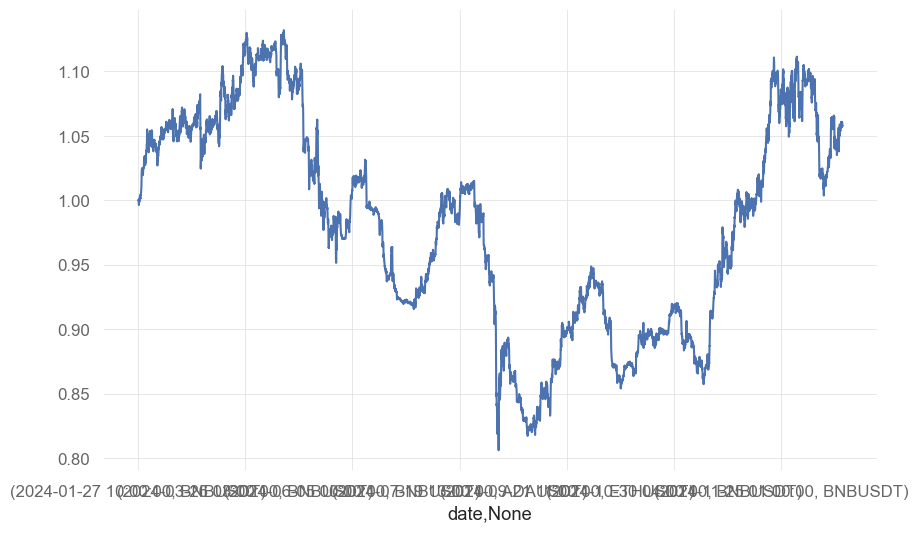

In [10]:
tf_strat_1.results.cstrategy.plot()

In [ ]:
(tf_strat_1.results.strategy * 1/4).cumsum().apply(np.exp).plot()

In [8]:
data.to_csv('sample_data.csv')    

In [67]:
#Create a dummy results that represents holding cash where the value of the portfolio is constant
cash_df = pd.DataFrame(data = {'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index = data.index)

In [68]:
cash_df

strategy  portfolio_value
date                coin                              
2020-01-01 01:00:00 ADAUSDT       0.0              1.0
                    BNBUSDT       0.0              1.0
                    BTCUSDT       0.0              1.0
                    ETHUSDT       0.0              1.0
                    XRPUSDT       0.0              1.0
...                               ...              ...
2020-12-31 23:00:00 ADAUSDT       0.0              1.0
                    BNBUSDT       0.0              1.0
                    BTCUSDT       0.0              1.0
                    ETHUSDT       0.0              1.0
                    XRPUSDT       0.0              1.0

[43825 rows x 2 columns]

In [186]:
strategy_map = {'cash_strat': cash_df.strategy,
                'mr_strat_1': mr_strat_1.results.strategy,
                'tf_strat_1': tf_strat_1.results.strategy}

---

Correlation Analysis

In [187]:
#Concatenate the results of the two strategies
list_strategies = [value for value in strategy_map.values()]
list_strategies

[date                 coin   
 2020-01-01 01:00:00  ADAUSDT    0.0
                      BNBUSDT    0.0
                      BTCUSDT    0.0
                      ETHUSDT    0.0
                      XRPUSDT    0.0
                                ... 
 2020-12-31 23:00:00  ADAUSDT    0.0
                      BNBUSDT    0.0
                      BTCUSDT    0.0
                      ETHUSDT    0.0
                      XRPUSDT    0.0
 Name: strategy, Length: 43825, dtype: float64,
 date                 coin   
 2020-01-25 12:00:00  ADAUSDT   -0.005726
                      ETHUSDT   -0.002410
 2020-01-25 13:00:00  ADAUSDT    0.004082
                      BTCUSDT    0.003204
                      ETHUSDT    0.006428
                                   ...   
 2020-10-10 17:00:00  XRPUSDT    0.000012
 2020-10-10 18:00:00  XRPUSDT    0.001073
 2020-10-10 19:00:00  XRPUSDT   -0.000597
 2020-10-10 20:00:00  XRPUSDT   -0.000476
 2020-11-13 04:00:00  ADAUSDT   -0.003856
 Name: strategy, Length

In [201]:
all_strategy = pd.concat(strategy_map, axis = 1)

In [202]:
all_strategy

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2020-01-01 01:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN
...                                 ...         ...         ...
2020-12-31 23:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN

[43825 rows x 3 columns]

In [203]:
#Get the correlation matrix
corr_matrix = all_strategy.corr()
corr_matrix

,cash_strat,mr_strat_1,tf_strat_1
cash_strat,NaN,NaN,NaN
mr_strat_1,NaN,1.000000,0.860956
tf_strat_1,NaN,0.860956,1.000000


In [204]:
corr_matrix.iloc[1, 2]

0.8609555080077618

In [205]:
def select_low_corr_strategies(corr_matrix, low_corr_threshold):
    """Selects strategies with low correlations from a correlation matrix."""
    selected_strategies = [corr_matrix.columns[1]]

    for i in range(1, len(corr_matrix.columns)):
        candidate_strategy = corr_matrix.columns[i]
        correlations_with_selected = corr_matrix.loc[selected_strategies, candidate_strategy]
        if all(corr < low_corr_threshold for corr in correlations_with_selected):
            selected_strategies.append(candidate_strategy)
    
    selected_strategies.append(corr_matrix.columns[0])
    return selected_strategies

In [206]:
selected = select_low_corr_strategies(corr_matrix, 0.9)

In [207]:
selected

['mr_strat_1', 'tf_strat_1', 'cash_strat']

In [211]:
#Get a new list for the selected strategies
filtered_strategies = {strategy_name : strategy for strategy_name, strategy in strategy_map.items() if strategy_name in selected}

In [215]:
filtered_strategy_map = pd.concat(filtered_strategies, axis = 1)
filtered_strategy_map

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2020-01-01 01:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN
...                                 ...         ...         ...
2020-12-31 23:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN

[43825 rows x 3 columns]

Putting All together:

In [222]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt


class Portfolio_Management():
    def __init__(self, strategy_map):
        self.strategy_map = strategy_map   
        
    def get_filtered_strategies(self, selected, strategy_map):
        """Filters the strategies based on the selected strategies."""
        filtered_strategies = {strategy_name : strategy for strategy_name, strategy in strategy_map.items() if strategy_name in selected}
        return pd.concat(filtered_strategies, axis = 1)
    
    def filter_by_correlation(self, low_corr_threshold = 0.9):
        """
        Filter the strategies by correlation
        """
        #Concatenate the map, to get one dataframe
        all_strategy = pd.concat(self.strategy_map, axis = 1)
    
        #Calculate the correlation matrix  
        corr_matrix = all_strategy.corr()

        #Perform the correlation analysis:
        selected_strategies = [corr_matrix.columns[1]]

        for i in range(1, len(corr_matrix.columns)):
            candidate_strategy = corr_matrix.columns[i]
            correlations_with_selected = corr_matrix.loc[selected_strategies, candidate_strategy]
            if all(corr < low_corr_threshold for corr in correlations_with_selected):
                selected_strategies.append(candidate_strategy)
        
        selected_strategies.append(corr_matrix.columns[0])
        
        
        #Get a new list for the selected strategies
        filtered_strategies = self.get_filtered_strategies(selected_strategies, self.strategy_map)
        
        return filtered_strategies

In [223]:
portfolio_management = Portfolio_Management(strategy_map)

In [224]:
portfolio_management.filter_by_correlation()

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2020-01-01 01:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN
...                                 ...         ...         ...
2020-12-31 23:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN

[43825 rows x 3 columns]